In [2]:
# generate longitude datas from cross section image
# author: eton.bi @ 240513
# !pip install pydicom
# !pip install pylibjpeg pylibjpeg ##for ERROR::RuntimeError: The following handlers are available to decode the pixel data however they are missing required dependencies: GDCM (req. GDCM), pylibjpeg (req. )
# https://pydicom.github.io/pydicom/stable/tutorials/dataset_basics.html#reading
# https://pydicom.github.io/pydicom/stable/guides/element_value_types.html
# https://dicom.nema.org/medical/dicom/current/output/chtml/part03/chapter_3.html#idp105553234661503

import pydicom
from pydicom import dcmread

import numpy as np

from  matplotlib import pyplot as plt
%matplotlib inline

In [3]:
dcmfileName=r"/media/eton/hdd931g/42-workspace4debian/70-DICOMs/dicom-series-005-MainSeries_Pre_LCX_RUN5(1-920).dcm"


In [4]:
ds = dcmread(dcmfileName) #By default, dcmread() will read any DICOM dataset stored in accordance with the DICOM File Format. 
print(ds)
for ele in ds:
    print(f"ele:{ele}")

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.1216481606.6984.1715563986.714
(0002, 0010) Transfer Syntax UID                 UI: JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.7
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_367'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'INTRAVASCULAR']
(0008, 0012) Instance Creation Date              DA: '20190420'
(0008, 0013) Instance Creation Time              TM: '172854'
(0008

In [5]:
#image_array = ds.pixel_array()
#ivusPullbackRate = float(ds.IVUSPullbackRate)
ivusPullbackRate=None
frameTimeVector=None
pullbackLength = None
imageArray = None

if ds.get('IVUSPullbackRate'):
    ivusPullbackRate = ds.MOTOR_PULLBACK
tagPullbackRate=0x000b1001
if ds.get(tagPullbackRate):
    tagitem = ds[tagPullbackRate]
    ivusPullbackRate = tagitem.value

frameTimeVector = ds.get('FrameTimeVector')
print(f"type={type(frameTimeVector)}", frameTimeVector[1:9])

pullbackTime = np.cumsum(frameTimeVector)/1000
print(f"type={type(pullbackTime)}", pullbackTime[1:9])

pullbackLength = pullbackTime*float(ivusPullbackRate)
print(f"type={type(pullbackLength)}", pullbackLength[1:9])

sur=ds.get('SequenceOfUltrasoundRegions')
print(f"sur:{sur}")
elepixelSpacing=ds.get_item('PixelSpacing')
pixelSpacing = ds.get('PixelSpacing')
print(f"PixelSpacing:{pixelSpacing}, tagEle={elepixelSpacing}")
image_rows=ds.get_item('Rows')
print(f"Rows:{image_rows}")
image_columns=ds.get_item('Columns')
print(f"Rcolumns:{image_columns}")

numberOfFrames = ds.get_item('NumberOfFrames')
print(f"NumberOfFrames:{numberOfFrames}")

imageArrayEle = ds.get_item('PixelData')
imageArray = ds.pixel_array
print(f"Pixel Data:{type(imageArray)}, shape={imageArray.shape}")

type=<class 'pydicom.multival.MultiValue'> ['35.96', '35.96', '35.94', '35.95', '35.93', '35.93', '35.96', '35.94']
type=<class 'numpy.ndarray'> [0.03596 0.07192 0.10786 0.14381 0.17974 0.21567 0.25163 0.28757]
type=<class 'numpy.ndarray'> [0.01798  0.03596  0.05393  0.071905 0.08987  0.107835 0.125815 0.143785]
sur:None
PixelSpacing:[0.01755671, 0.01755671], tagEle=(0028, 0030) Pixel Spacing                       DS: [0.01755671, 0.01755671]
Rows:(0028, 0010) Rows                                US: 512
Rcolumns:(0028, 0011) Columns                             US: 512
NumberOfFrames:(0028, 0008) Number of Frames                    IS: '951'
Pixel Data:<class 'numpy.ndarray'>, shape=(951, 512, 512, 3)


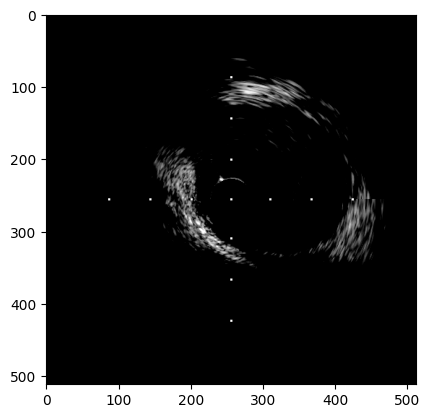

In [6]:
imgIdx = 33
oneImage = imageArray[imgIdx, :, :,0]
plt.imshow(oneImage, cmap="gray")

coordinate.shape=512, type=<class 'list'>


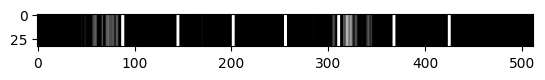

In [10]:
import math

def getLongitudeLineFromOneImg(theta, imageData):
    theta = theta * np.pi / 180
    #theta = - theta # y-axis reverse in image coordinate
    edgeL = imageData.shape[0]
    R = edgeL//2 #-1
    maxPos = edgeL-1
    minPos = 0
    outlineCoordinates = []
    for ir in range(-R, R):#[-256,255]
        ix = round(ir * np.cos(theta))
        iy = round(ir * np.sin(theta))
        
        ix += R
        iy += R
        
        #print(f"ix={ix}, iy={iy}, min={minPos}, max={maxPos}, R={R}")
        ix = max(min(maxPos, ix),minPos)
        iy = max(min(maxPos, iy),minPos)
        outlineCoordinates.append((ix,iy))
    return outlineCoordinates
        
outl = getLongitudeLineFromOneImg(-90, oneImage)
#print(f"outline: len={len(outl)}, cos(30)={np.cos(30 * np.pi / 180)}")
#print(f"{outl}")

def getImagePixelValueByCoordinates(coords, imageData):
    #print(f"coordinate.shape={len(coords)}, type={type(coords)}")
    pixelLine = []
    for ico in coords:
        pixelV = imageData[ico[0], ico[1]]
        pixelLine.append(pixelV)
        #print(f"type={type(ico)}, x,y={ico},pixel value={pixelV}")
    return np.array(pixelLine)
    
oneLine = getImagePixelValueByCoordinates(outl, oneImage)
omg = oneLine.reshape(1, oneLine.shape[0])
#print(oneLine)
for i in range(32):
    omg = np.concatenate((omg.copy(), oneLine.reshape(1, oneLine.shape[0])), axis=0)
plt.imshow(omg,cmap='gray')


coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 

coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 

coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 'list'>
coordinate.shape=512, type=<class 

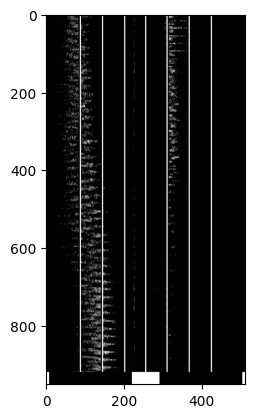

In [11]:
for imgIdx in range(imageArray.shape[0]):
    oneImage = imageArray[imgIdx, :, :,0]
    outl = getLongitudeLineFromOneImg(-90, oneImage)
    oneLine = getImagePixelValueByCoordinates(outl, oneImage)
    omgOne = oneLine.reshape(1, oneLine.shape[0])
    if 0 == imgIdx:
        omg = omgOne
    else:
        omg = np.concatenate((omg.copy(), omgOne), axis=0)
plt.imshow(omg,cmap='gray')

In [38]:
class LViewData():
    """Creates an lview and returns the image"""
    def __init__(self, image_dim):

        self.current_angle = 0
        spacing = np.linspace(0, image_dim[1], image_dim[2])
        x, y = np.meshgrid(spacing, spacing)
        half_dim = image_dim[1]//2
        x = x - half_dim
        y = y - half_dim
        #self.rho = np.sqrt(x**2 + y**2)
        phi = np.arctan2(y, x)
        phi += np.pi
        phi = phi*180/np.pi
        self.phi1 = phi[:, :half_dim]
        self.phi2 = phi[:, half_dim:]   
        self.phi3 = phi[:half_dim, :]
        self.phi4 = phi[half_dim:, :]
        self.phi = phi
        self.idx1_1 = np.linspace(0, half_dim - 1, half_dim, dtype=np.uint16)
        self.idx2_1 = np.linspace(half_dim, image_dim[1] - 1, half_dim, dtype=np.uint16)
        print(f"{image_dim}")

    def update(self, images, current_angle):  
        self.current_angle = current_angle
        #if self.current_angle > 90 and self.current_angle < 270:
        #    self.current_angle = 360 - self.current_angle
        #print("New angle:", self.current_angle, (180 + self.current_angle)%360)
        if 45 < self.current_angle <= 135:
        #if self.current_angle <= 45 or self.current_angle > 315:
            idx1_2 = np.abs((self.phi3 - self.current_angle)).argmin(axis=1)
            idx2_2 = np.abs((self.phi4 - (180 + self.current_angle)%360)).argmin(axis=1)
            idx1 = np.concatenate([self.idx1_1, self.idx2_1])
            idx2 = np.concatenate([idx1_2, idx2_2])    
            #lview_array = images[:, idx1, idx2].astype(np.uint8, order='C', casting='unsafe')
        elif 225 < self.current_angle <= 315:
            idx1_2 = np.abs((self.phi3 - (180 + self.current_angle)%360)).argmin(axis=1)
            idx2_2 = np.abs((self.phi4 - self.current_angle)).argmin(axis=1)
            idx1 = np.concatenate([self.idx1_1, self.idx2_1])
            idx2 = np.concatenate([idx1_2, idx2_2])    
            #lview_array = images[:, idx1, idx2].astype(np.uint8, order='C', casting='unsafe')        
        elif 135 < self.current_angle <= 225:
            idx1_2 = np.abs((self.phi1 - (180 + self.current_angle)%360)).argmin(axis=0)
            idx2_2 = np.abs((self.phi2 - self.current_angle)).argmin(axis=0)
            idx2 = np.concatenate([self.idx1_1, self.idx2_1])
            idx1 = np.concatenate([idx1_2, idx2_2])        
            #lview_array = images[:, idx2, idx1].astype(np.uint8, order='C', casting='unsafe')
        else:
            idx1_2 = np.abs((self.phi1 - self.current_angle)).argmin(axis=0)
            idx2_2 = np.abs((self.phi2 - (180 + self.current_angle)%360)).argmin(axis=0)
            idx2 = np.concatenate([self.idx1_1, self.idx2_1])
            idx1 = np.concatenate([idx1_2, idx2_2])
        
        
        lview_array = images[:, idx1, idx2].astype(np.uint8, order='C', casting='unsafe')
        lview_array = lview_array[:,:,0]
        print(f"shape=", lview_array.shape) #(951, 512, 3)
        lview_array = np.transpose(lview_array, (1, 0)).copy()

        print(f"shape2=", lview_array.shape) #(951, 512, 3)
        if 135 <= self.current_angle <= 315:
            lview_array = np.flipud(lview_array).copy()

        return lview_array
    
lview_data = LViewData(imageArray.shape)

(951, 512, 512, 3)


In [39]:
current_angle=0
lview_array=lview_data.update(imageArray, current_angle)

shape= (951, 512)
shape2= (512, 951)


type<class 'numpy.ndarray'>, shape=(512, 951)


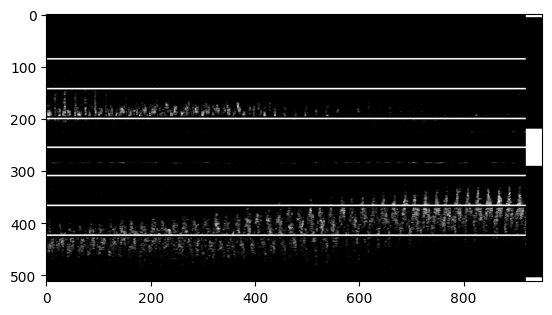

In [40]:
print(f"type{type(lview_array)}, shape={lview_array.shape}")


plt.imshow(lview_array,cmap='gray')


shape= (951, 512)
shape2= (512, 951)


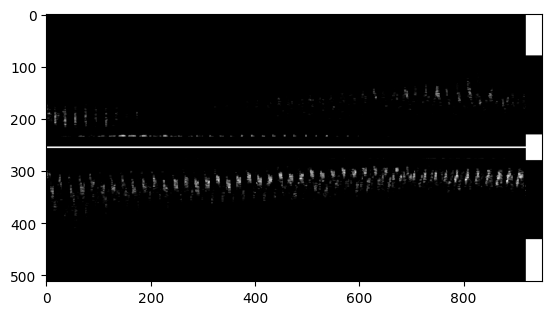

In [41]:
lview_array=lview_data.update(imageArray, 45)
plt.imshow(lview_array, cmap='gray')

In [139]:
a = np.array([1, 2, 3])
a2 = np.array([31, 2, 3])
b=a.reshape(1,3)
print(a.shape, b.shape)

#c = np.stack(b, a2)
c=np.concatenate((b, a2.reshape(1,3)), axis=0)
print(c)


(3,) (1, 3)
[[ 1  2  3]
 [31  2  3]]


In [ ]:
import cv2
%matplotlib inline
import numpy as np

#numpy array
ndarray = np.full((300,300,3), 125, dtype=np.uint8)
 
#show image
#//cv2.imshow('Example - Show image in window', ndarray)

In [115]:
for i in range(10):
    x0 = 5.76543+(i/10)
    x = round(x0)
    print(x0, x)

5.76543 6
5.86543 6
5.9654300000000005 6
6.06543 6
6.165430000000001 6
6.26543 6
6.36543 6
6.4654300000000005 6
6.56543 7
6.665430000000001 7


shape=(3,), values=[0.  1.5 3. ]
meshgrid: x=<class 'numpy.ndarray'>, shape=(3, 3), values=[[0.  1.5 3. ]
 [0.  1.5 3. ]
 [0.  1.5 3. ]]
meshgrid: x=<class 'numpy.ndarray'>, shape=(3, 3), values=[[-1.  -1.  -1. ]
 [ 0.5  0.5  0.5]
 [ 2.   2.   2. ]]
phi=[[-2.35619449 -1.10714872 -0.46364761]
 [ 2.67794504  0.78539816  0.24497866]
 [ 2.03444394  1.32581766  0.78539816]]
phi=[[ 45.         116.56505118 153.43494882]
 [333.43494882 225.         194.03624347]
 [296.56505118 255.96375653 225.        ]]


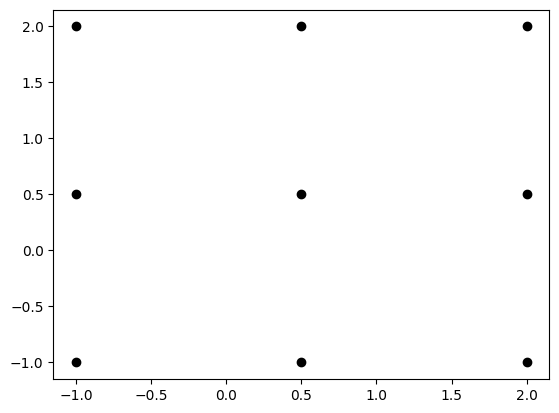

In [51]:
#(951, 512, 512, 3)
center = 1
pixelSteps=np.linspace(0, 3,3)
print(f"shape={pixelSteps.shape}, values={pixelSteps}")
x,y = np.meshgrid(pixelSteps, pixelSteps)
print(f"meshgrid: x={type(x)}, shape={x.shape}, values={x}")
x = x-center
y=y - center
print(f"meshgrid: x={type(y)}, shape={y.shape}, values={y}")
plt.plot(x,y,marker='o', color='k', linestyle='none')

phi = np.arctan2(y, x)
print(f"phi={phi}")
phi += np.pi
phi = 180 * phi / np.pi

print(f"phi={phi}")

In [37]:
a = 33
print(a//2, a/2)
x = x +100
print(x)

16 16.5
[[100.   100.25 100.5  100.75 101.  ]
 [100.   100.25 100.5  100.75 101.  ]]


In [56]:
a1=np.array([1,2,3])
a2=np.array([3,4,6])
a1xa2, x2xa1=np.meshgrid(a1, a2)
a1_a2=np.concatenate([a1, a2])
print(a1_a2, a1xa2)

[1 2 3 3 4 6] [[1 2 3]
 [1 2 3]
 [1 2 3]]


In [64]:
ab=a1>2
print(ab)
print(a1xa2[ab,ab])

[False False  True]
[3]
